<a href="https://colab.research.google.com/github/avaniishh123/COE-Internship-DL-Project/blob/main/COE_DL_Project_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import glob
import random
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt


In [18]:
IMG_SIZE = 256
BATCH_SIZE = 8
SRC_IMG_DIR  = "/content/polyp_data/unified_final/source/images"
SRC_MASK_DIR = "/content/polyp_data/unified_final/source/masks"
TGT_IMG_DIR  = "/content/polyp_data/unified_final/target/images"
CHECKPOINT_DIR = "/content/checkpoints_adapt"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
EPOCHS = 30
LEARNING_RATE = 2e-4
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)

In [19]:
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 127.5 - 1.0  # [-1,1]
    return img

def read_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_image(m, channels=1, expand_animations=False)
    m = tf.image.resize(m, [IMG_SIZE, IMG_SIZE], method='nearest')
    m = tf.cast(m, tf.float32) / 255.0
    m = tf.clip_by_value(m, 0.0, 1.0)
    return m

def random_flip_rotate(image, mask=None):
    # simple augmentations
    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_left_right(image)
        if mask is not None: mask = tf.image.flip_left_right(mask)
    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_up_down(image)
        if mask is not None: mask = tf.image.flip_up_down(mask)
    # small rotation
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    if mask is not None: mask = tf.image.rot90(mask, k)
    return (image, mask) if mask is not None else image

In [20]:
def make_source_dataset(img_dir, mask_dir, batch_size=BATCH_SIZE, augment=True):
    img_paths = sorted([p for p in glob.glob(os.path.join(img_dir, "*"))])
    mask_paths = sorted([p for p in glob.glob(os.path.join(mask_dir, "*"))])
    pairs = []
    # match by end-of-filename base (handles your prefixes like kvasir__xxx)
    for ip in img_paths:
        base = os.path.splitext(os.path.basename(ip))[0].split("__")[-1]
        matches = [m for m in mask_paths if os.path.splitext(os.path.basename(m))[0].endswith(base)]
        if matches:
            pairs.append((ip, matches[0]))
    print("Source pairs:", len(pairs))
    img_t = [p[0] for p in pairs]; mask_t = [p[1] for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_t, mask_t))
    def _map(i, m):
        img = read_image(i); mask = read_mask(m)
        if augment:
            img, mask = random_flip_rotate(img, mask)
        return img, mask
    ds = ds.shuffle(1024).map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def make_target_dataset(img_dir, batch_size=BATCH_SIZE, augment=False):
    img_paths = sorted([p for p in glob.glob(os.path.join(img_dir, "*")) if os.path.getsize(p) > 0])
    print("Target images:", len(img_paths))
    ds = tf.data.Dataset.from_tensor_slices(img_paths)
    def _map(i):
        img = read_image(i)
        if augment:
            img = random_flip_rotate(img)  # returns image only
        return img
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

src_ds = make_source_dataset(SRC_IMG_DIR, SRC_MASK_DIR, BATCH_SIZE, augment=True)
tgt_ds = make_target_dataset(TGT_IMG_DIR, BATCH_SIZE, augment=False)


Source pairs: 1612
Target images: 612


In [21]:
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x
    c1 = conv_block(inputs, 32); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPool2D()(c4)
    b = conv_block(p4, 512)
    u1 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u1 = layers.Concatenate()([u1, c4]); u1 = conv_block(u1, 256)
    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(u1)
    u2 = layers.Concatenate()([u2, c3]); u2 = conv_block(u2, 128)
    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(u2)
    u3 = layers.Concatenate()([u3, c2]); u3 = conv_block(u3, 64)
    u4 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(u3)
    u4 = layers.Concatenate()([u4, c1]); u4 = conv_block(u4, 32)
    out = layers.Conv2D(1, 1, activation='sigmoid')(u4)
    return models.Model(inputs, out, name="UNet")

# PatchGAN discriminator that takes single-channel mask-like input
def build_discriminator(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, 4, strides=1, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)  # logits
    return models.Model(inp, x, name="PatchGAN")

generator = build_unet()
discriminator = build_discriminator()
print(generator.summary())
print(discriminator.summary())

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_28[0][0] 

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

None


Model: "PatchGAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 128, 128, 64)   │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,273 (10.55 MB)

 Trainable params: 2,764,481 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

None


In [22]:
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # for mask-level if needed

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def seg_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))

def disc_loss_fn(real_logits, fake_logits):
    real_loss = bce_logits(tf.ones_like(real_logits), real_logits)
    fake_loss = bce_logits(tf.zeros_like(fake_logits), fake_logits)
    return 0.5 * (real_loss + fake_loss)

def gen_adv_loss_fn(fake_logits):
    return bce_logits(tf.ones_like(fake_logits), fake_logits)

gen_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)


In [23]:
train_summary_writer = None

# -------------------------
# Training step (source supervised + adversarial + pseudo-target self-train)
# -------------------------
@tf.function
def train_step(src_images, src_masks, tgt_images, pseudo_threshold=0.9, adv_weight=0.01, pseudo_weight=0.5):
    # src_images: [B, H, W, 3], src_masks: [B, H, W, 1], tgt_images: [B, H, W, 3]
    with tf.GradientTape(persistent=True) as tape:
        # generator predictions
        pred_src = generator(src_images, training=True)   # [B,H,W,1]
        pred_tgt = generator(tgt_images, training=True)

        # discriminator outputs (logits)
        d_real = discriminator(src_masks, training=True)
        d_fake_src = discriminator(pred_src, training=True)
        d_fake_tgt = discriminator(pred_tgt, training=True)  # optional: push target preds toward 'real' too

        # segmentation supervised loss on source
        seg_l = seg_loss(src_masks, pred_src)

        # generator adversarial loss (wants discriminator to classify fake as real)
        gen_adv_src = gen_adv_loss_fn(d_fake_src)
        gen_adv_tgt = gen_adv_loss_fn(d_fake_tgt)

        # combine generator losses
        gen_total = seg_l + adv_weight * (gen_adv_src + gen_adv_tgt)

        # discriminator loss (real vs fake from source)
        disc_loss = disc_loss_fn(d_real, d_fake_src)

        # --- pseudo-labeling: create high-confidence pseudo masks for target and supervise on them ---
        # We can't use argmax in tf.function safely for float thresholding; we use mask of high-confidence
        high_conf_mask = tf.cast(pred_tgt > pseudo_threshold, tf.float32)
        high_conf_ratio = tf.reduce_mean(high_conf_mask)  # fraction of positive pixels (useful debug)
        # apply supervision only where positive OR negative are highly confident? Here we use positive high confidence
        # compute pseudo supervision loss only on locations that are high_conf_mask (reduce noisy labels)
        pseudo_loss = 0.0
        if tf.reduce_sum(high_conf_mask) > 0.0:
            # compute BCE or dice on masked regions (we use BCE)
            masked_pred = tf.boolean_mask(pred_tgt, tf.reshape(high_conf_mask, [-1])==1)
            masked_label = tf.boolean_mask(high_conf_mask, tf.reshape(high_conf_mask, [-1])==1)
            # if masked_pred empty -> skip; else compute binary crossentropy
            pseudo_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(masked_label, masked_pred))
            gen_total += pseudo_weight * pseudo_loss

    # gradients and apply
    grads_g = tape.gradient(gen_total, generator.trainable_variables)
    grads_d = tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_opt.apply_gradients(zip(grads_g, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    return {
        "gen_total": gen_total,
        "seg_l": seg_l,
        "gen_adv_src": gen_adv_src,
        "gen_adv_tgt": gen_adv_tgt,
        "disc_loss": disc_loss,
        "pseudo_loss": pseudo_loss,
        "high_conf_ratio": high_conf_ratio
    }

# -------------------------
# Evaluation helpers
# -------------------------
def compute_metrics_on_batch(y_true, y_pred):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin)
    dice = (2.0 * intersection + 1e-6) / (union + 1e-6)
    # IoU (Jaccard)
    inter = intersection
    jo = (inter + 1e-6) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - inter + 1e-6)
    return dice.numpy(), jo.numpy()

In [25]:
@tf.function
def train_step(src_images, src_masks, tgt_images, pseudo_threshold=0.9, adv_weight=0.01, pseudo_weight=0.5):
    with tf.GradientTape(persistent=True) as tape:
        # Generator predictions
        pred_src = generator(src_images, training=True)
        pred_tgt = generator(tgt_images, training=True)

        # Discriminator outputs
        d_real = discriminator(src_masks, training=True)
        d_fake_src = discriminator(pred_src, training=True)
        d_fake_tgt = discriminator(pred_tgt, training=True)

        # Losses
        seg_l = seg_loss(src_masks, pred_src)
        gen_adv_src = gen_adv_loss_fn(d_fake_src)
        gen_adv_tgt = gen_adv_loss_fn(d_fake_tgt)

        gen_total = seg_l + adv_weight * (gen_adv_src + gen_adv_tgt)
        disc_loss = disc_loss_fn(d_real, d_fake_src)

        # --- pseudo-label self-training (fixed) ---
        pseudo_loss = 0.0
        high_conf_mask = tf.cast(pred_tgt > pseudo_threshold, tf.float32)
        high_conf_ratio = tf.reduce_mean(high_conf_mask)

        # Flatten before masking
        flat_pred = tf.reshape(pred_tgt, [-1])
        flat_mask = tf.reshape(high_conf_mask, [-1])

        selected_pred = tf.boolean_mask(flat_pred, flat_mask > 0)
        selected_label = tf.boolean_mask(flat_mask, flat_mask > 0)

        # Only compute pseudo-loss if we have confident pixels
        num_conf = tf.size(selected_pred)
        def compute_pseudo():
            return tf.reduce_mean(tf.keras.losses.binary_crossentropy(selected_label, selected_pred))
        pseudo_loss = tf.cond(num_conf > 0, compute_pseudo, lambda: 0.0)

        gen_total += pseudo_weight * pseudo_loss

    # Apply gradients
    grads_g = tape.gradient(gen_total, generator.trainable_variables)
    grads_d = tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_opt.apply_gradients(zip(grads_g, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return {
        "gen_total": gen_total,
        "seg_l": seg_l,
        "gen_adv_src": gen_adv_src,
        "gen_adv_tgt": gen_adv_tgt,
        "disc_loss": disc_loss,
        "pseudo_loss": pseudo_loss,
        "high_conf_ratio": high_conf_ratio,
    }


In [27]:
# Training loop
# -------------------------
best_val_dice = -1.0
global_step = 0
for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")
    pbar = tqdm(zip(src_ds, tgt_ds.repeat()), total=min(len(list(src_ds)), len(list(tgt_ds))))
    stats = {"gen_total": [], "seg_l": [], "gen_adv_src": [], "gen_adv_tgt": [], "disc_loss": [], "pseudo_loss": [], "high_conf_ratio": []}
    for (src_imgs, src_masks), tgt_imgs in pbar:
        tgt_imgs = tgt_imgs  # shaped [B, H, W, 3]
        res = train_step(src_imgs, src_masks, tgt_imgs)
        for k,v in res.items():
            stats[k].append(float(v.numpy()))
        global_step += 1
        pbar.set_description(f"g:{np.mean(stats['gen_total']):.4f} s:{np.mean(stats['seg_l']):.4f} d:{np.mean(stats['disc_loss']):.4f}")

    # epoch summary
    print("Epoch summary:",
          f"Gen:{np.mean(stats['gen_total']):.4f}",
          f"Seg:{np.mean(stats['seg_l']):.4f}",
          f"Disc:{np.mean(stats['disc_loss']):.4f}",
          f"PseudoLoss:{np.mean(stats['pseudo_loss']):.4f}",
          f"HighConfRatio:{np.mean(stats['high_conf_ratio']):.4f}")

    # Save weights each epoch
    generator.save_weights(os.path.join(CHECKPOINT_DIR, f"generator_epoch_{epoch+1}.weights.h5"))
    discriminator.save_weights(os.path.join(CHECKPOINT_DIR, f"discriminator_epoch_{epoch+1}.weights.h5"))



=== Epoch 1/30 ===


g:1.0436 s:0.9592 d:0.0400: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:1.0436 Seg:0.9592 Disc:0.0400 PseudoLoss:0.0239 HighConfRatio:0.2791

=== Epoch 2/30 ===


g:0.9141 s:0.8421 d:0.0964: : 202it [03:16,  1.03it/s]


Epoch summary: Gen:0.9141 Seg:0.8421 Disc:0.0964 PseudoLoss:0.0200 HighConfRatio:0.3186

=== Epoch 3/30 ===


g:0.8324 s:0.7575 d:0.0430: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.8324 Seg:0.7575 Disc:0.0430 PseudoLoss:0.0173 HighConfRatio:0.3212

=== Epoch 4/30 ===


g:0.7506 s:0.6788 d:0.0224: : 202it [02:22,  1.42it/s]


Epoch summary: Gen:0.7506 Seg:0.6788 Disc:0.0224 PseudoLoss:0.0137 HighConfRatio:0.3253

=== Epoch 5/30 ===


g:0.6853 s:0.6170 d:0.0949: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.6853 Seg:0.6170 Disc:0.0949 PseudoLoss:0.0122 HighConfRatio:0.3259

=== Epoch 6/30 ===


g:0.6274 s:0.5700 d:0.0880: : 202it [02:22,  1.42it/s]


Epoch summary: Gen:0.6274 Seg:0.5700 Disc:0.0880 PseudoLoss:0.0131 HighConfRatio:0.3587

=== Epoch 7/30 ===


g:0.5895 s:0.5290 d:0.1156: : 202it [02:21,  1.42it/s]


Epoch summary: Gen:0.5895 Seg:0.5290 Disc:0.1156 PseudoLoss:0.0114 HighConfRatio:0.3680

=== Epoch 8/30 ===


g:0.5657 s:0.5147 d:0.1123: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.5657 Seg:0.5147 Disc:0.1123 PseudoLoss:0.0124 HighConfRatio:0.3954

=== Epoch 9/30 ===


g:0.5471 s:0.4958 d:0.1348: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.5471 Seg:0.4958 Disc:0.1348 PseudoLoss:0.0095 HighConfRatio:0.3791

=== Epoch 10/30 ===


g:0.5346 s:0.4846 d:0.1401: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.5346 Seg:0.4846 Disc:0.1401 PseudoLoss:0.0084 HighConfRatio:0.3893

=== Epoch 11/30 ===


g:0.5083 s:0.4646 d:0.1612: : 202it [03:16,  1.03it/s]


Epoch summary: Gen:0.5083 Seg:0.4646 Disc:0.1612 PseudoLoss:0.0079 HighConfRatio:0.4022

=== Epoch 12/30 ===


g:0.5214 s:0.4691 d:0.1015: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.5214 Seg:0.4691 Disc:0.1015 PseudoLoss:0.0081 HighConfRatio:0.4222

=== Epoch 13/30 ===


g:0.5151 s:0.4624 d:0.1142: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.5151 Seg:0.4624 Disc:0.1142 PseudoLoss:0.0054 HighConfRatio:0.3784

=== Epoch 14/30 ===


g:0.5068 s:0.4608 d:0.1474: : 202it [02:21,  1.42it/s]


Epoch summary: Gen:0.5068 Seg:0.4608 Disc:0.1474 PseudoLoss:0.0065 HighConfRatio:0.4176

=== Epoch 15/30 ===


g:0.4991 s:0.4486 d:0.0743: : 202it [02:21,  1.42it/s]


Epoch summary: Gen:0.4991 Seg:0.4486 Disc:0.0743 PseudoLoss:0.0064 HighConfRatio:0.4353

=== Epoch 16/30 ===


g:0.4980 s:0.4475 d:0.1100: : 202it [02:21,  1.42it/s]


Epoch summary: Gen:0.4980 Seg:0.4475 Disc:0.1100 PseudoLoss:0.0060 HighConfRatio:0.4379

=== Epoch 17/30 ===


g:0.4961 s:0.4479 d:0.1223: : 202it [02:22,  1.42it/s]


Epoch summary: Gen:0.4961 Seg:0.4479 Disc:0.1223 PseudoLoss:0.0052 HighConfRatio:0.4145

=== Epoch 18/30 ===


g:0.4845 s:0.4407 d:0.1659: : 202it [02:22,  1.42it/s]


Epoch summary: Gen:0.4845 Seg:0.4407 Disc:0.1659 PseudoLoss:0.0052 HighConfRatio:0.4272

=== Epoch 19/30 ===


g:0.4765 s:0.4361 d:0.1692: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4765 Seg:0.4361 Disc:0.1692 PseudoLoss:0.0063 HighConfRatio:0.4614

=== Epoch 20/30 ===


g:0.4829 s:0.4362 d:0.1716: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4829 Seg:0.4362 Disc:0.1716 PseudoLoss:0.0075 HighConfRatio:0.4976

=== Epoch 21/30 ===


g:0.4720 s:0.4284 d:0.1396: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4720 Seg:0.4284 Disc:0.1396 PseudoLoss:0.0076 HighConfRatio:0.5373

=== Epoch 22/30 ===


g:0.4830 s:0.4326 d:0.0664: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4830 Seg:0.4326 Disc:0.0664 PseudoLoss:0.0062 HighConfRatio:0.5337

=== Epoch 23/30 ===


g:0.4786 s:0.4332 d:0.1568: : 202it [03:09,  1.07it/s]


Epoch summary: Gen:0.4786 Seg:0.4332 Disc:0.1568 PseudoLoss:0.0066 HighConfRatio:0.5609

=== Epoch 24/30 ===


g:0.4820 s:0.4267 d:0.1606: : 202it [03:14,  1.04it/s]


Epoch summary: Gen:0.4820 Seg:0.4267 Disc:0.1606 PseudoLoss:0.0052 HighConfRatio:0.5185

=== Epoch 25/30 ===


g:0.4585 s:0.4192 d:0.2455: : 202it [03:14,  1.04it/s]


Epoch summary: Gen:0.4585 Seg:0.4192 Disc:0.2455 PseudoLoss:0.0046 HighConfRatio:0.5065

=== Epoch 26/30 ===


g:0.4804 s:0.4325 d:0.1437: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4804 Seg:0.4325 Disc:0.1437 PseudoLoss:0.0058 HighConfRatio:0.5611

=== Epoch 27/30 ===


g:0.4774 s:0.4346 d:0.2124: : 202it [03:15,  1.04it/s]


Epoch summary: Gen:0.4774 Seg:0.4346 Disc:0.2124 PseudoLoss:0.0042 HighConfRatio:0.5220

=== Epoch 28/30 ===


g:0.4595 s:0.4245 d:0.2404: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4595 Seg:0.4245 Disc:0.2404 PseudoLoss:0.0044 HighConfRatio:0.5574

=== Epoch 29/30 ===


g:0.4641 s:0.4215 d:0.1693: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4641 Seg:0.4215 Disc:0.1693 PseudoLoss:0.0048 HighConfRatio:0.5933

=== Epoch 30/30 ===


g:0.4673 s:0.4292 d:0.2079: : 202it [02:21,  1.43it/s]


Epoch summary: Gen:0.4673 Seg:0.4292 Disc:0.2079 PseudoLoss:0.0048 HighConfRatio:0.6034


In [31]:
import cv2
import numpy as np

def clean_mask(mask):
    mask = (mask * 255).astype(np.uint8)
    # remove tiny dots
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    # fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    mask = (mask > 127).astype(np.uint8)
    return mask



Visual check on target (ETIS) images (cleaned):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


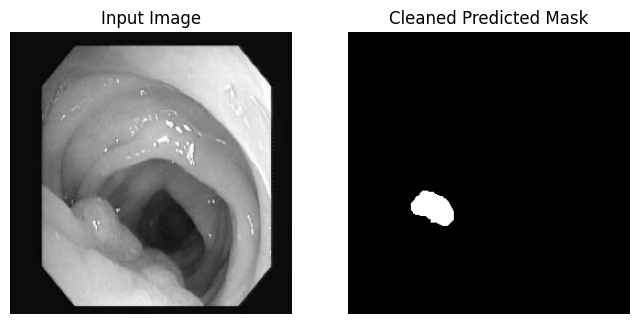

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


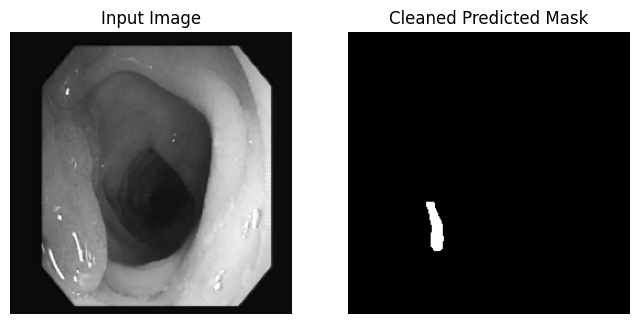

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


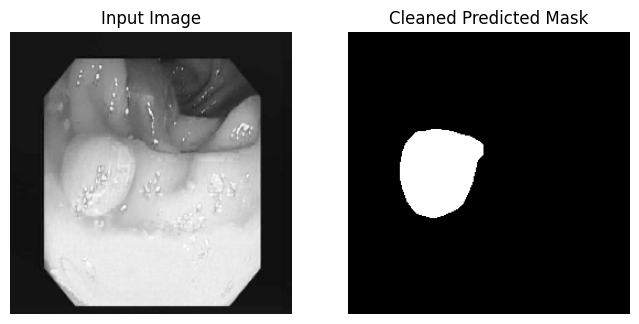

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


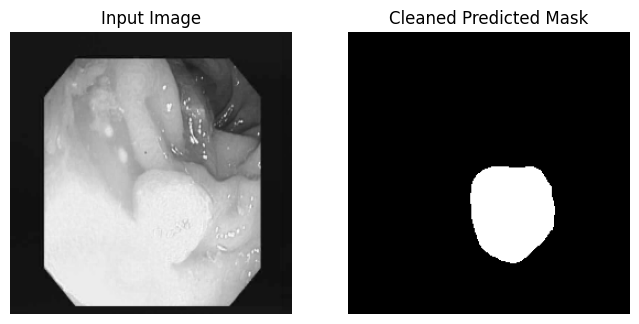

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


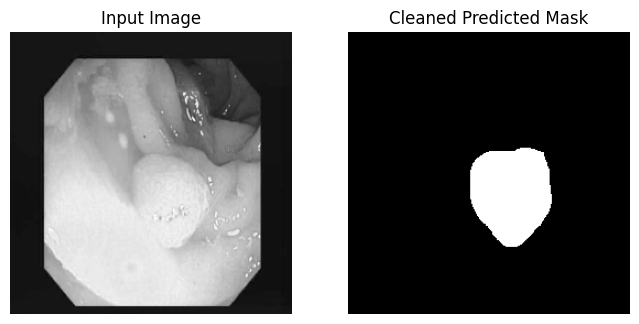

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


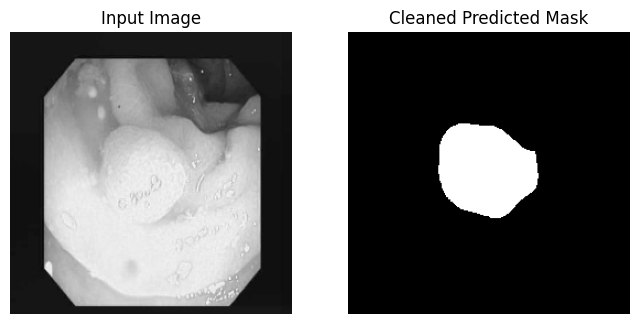

In [36]:
import cv2, glob, numpy as np, matplotlib.pyplot as plt

# Clean small dots and holes
def clean_mask(mask):
    mask = (mask * 255).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    # keep only the largest contour (main ulcer/polyp)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        new_mask = np.zeros_like(mask)
        cv2.drawContours(new_mask, [largest], -1, 255, -1)
        mask = new_mask
    mask = (mask > 127).astype(np.uint8)
    return mask


def show_predictions_on_dir(gen, img_dir, n=6):
    imgs = sorted([p for p in glob.glob(os.path.join(img_dir, "*"))])[:n]
    for p in imgs:
        orig = cv2.imread(p)
        if orig is None:
            continue
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        img = cv2.resize(orig, (256, 256))
        inp = (img.astype(np.float32) / 127.5) - 1.0
        pred = gen.predict(np.expand_dims(inp, 0))[0, :, :, 0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        # 🧹 Clean mask here
        pred_bin = clean_mask(pred_bin)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img.astype('uint8'))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_bin, cmap='gray')
        plt.title("Cleaned Predicted Mask")
        plt.axis("off")
        plt.show()

print("\nVisual check on target (ETIS) images (cleaned):")
show_predictions_on_dir(generator, TGT_IMG_DIR, n=6)


In [42]:
import tensorflow as tf

def ensure_4d(x):
    """Ensures tensor shape is (B, H, W, 1)"""
    x = tf.cast(x, tf.float32)
    if len(x.shape) == 3:
        x = tf.expand_dims(x, -1)
    return x

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = ensure_4d(y_true)
    y_pred = ensure_4d(y_pred)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    y_true = ensure_4d(y_true)
    y_pred = ensure_4d(y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    return tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * bce)

def seg_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * focal_loss(y_true, y_pred)


In [45]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute BCE manually (avoid shape squeezing)
    eps = 1e-7
    y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

    # Focal scaling
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal = alpha * tf.pow(1. - pt, gamma) * bce
    return tf.reduce_mean(focal)

def seg_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * focal_loss(y_true, y_pred)


In [46]:
opt = tf.keras.optimizers.Adam(1e-5)
for epoch in range(10):
    losses = []
    for imgs, masks in make_source_dataset(KVASIR_IMG_DIR, KVASIR_MASK_DIR, batch_size=8, augment=True):
        with tf.GradientTape() as tape:
            preds = generator(imgs, training=True)
            loss = seg_loss(masks, preds)
        grads = tape.gradient(loss, generator.trainable_variables)
        opt.apply_gradients(zip(grads, generator.trainable_variables))
        losses.append(loss.numpy())
    print(f"Kvasir fine-tune epoch {epoch+1}: {np.mean(losses):.4f}")

generator.save_weights("/content/checkpoints_adapt/generator_finetuned_kvasir_final.weights.h5")
print("✅ Fine-tuning completed and saved!")


Source pairs: 1000
Kvasir fine-tune epoch 1: 0.0983
Source pairs: 1000
Kvasir fine-tune epoch 2: 0.0927
Source pairs: 1000
Kvasir fine-tune epoch 3: 0.0923
Source pairs: 1000
Kvasir fine-tune epoch 4: 0.0900
Source pairs: 1000
Kvasir fine-tune epoch 5: 0.0914
Source pairs: 1000
Kvasir fine-tune epoch 6: 0.0906
Source pairs: 1000
Kvasir fine-tune epoch 7: 0.0858
Source pairs: 1000
Kvasir fine-tune epoch 8: 0.0858
Source pairs: 1000
Kvasir fine-tune epoch 9: 0.0823
Source pairs: 1000
Kvasir fine-tune epoch 10: 0.0847
✅ Fine-tuning completed and saved!


In [60]:
import cv2
import numpy as np
from skimage.morphology import remove_small_objects, remove_small_holes

def clean_mask(pred_mask):
    pred_mask = pred_mask.astype(np.float32)
    # Slightly higher threshold
    pred_mask = (pred_mask > 0.65).astype(np.uint8)

    # Morphological clean-up
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    # Remove tiny false regions
    pred_mask = remove_small_objects(pred_mask.astype(bool), min_size=800)
    pred_mask = remove_small_holes(pred_mask, area_threshold=800)

    # Final erosion (tighten mask boundary)
    pred_mask = cv2.erode(pred_mask.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1)

    return pred_mask.astype(np.float32)


In [61]:
import matplotlib.pyplot as plt

def show_overlay(image, mask, alpha=0.4):
    """Overlay predicted mask on the input image."""
    overlay = image.copy()
    overlay = (overlay - overlay.min()) / (overlay.max() - overlay.min())  # normalize
    mask_colored = np.zeros_like(overlay)
    mask_colored[..., 1] = mask[..., 0]  # green mask
    blended = (1 - alpha) * overlay + alpha * mask_colored
    plt.imshow(blended)
    plt.axis("off")


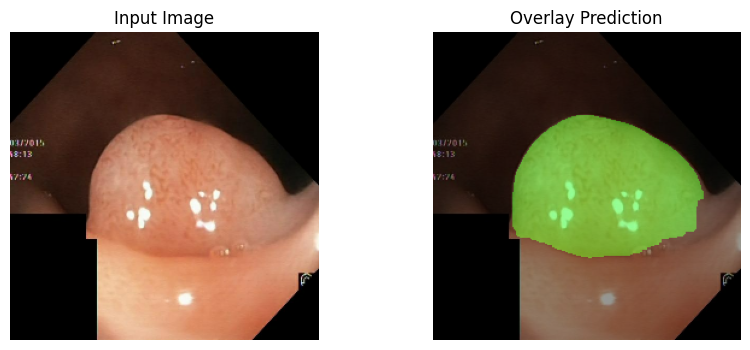

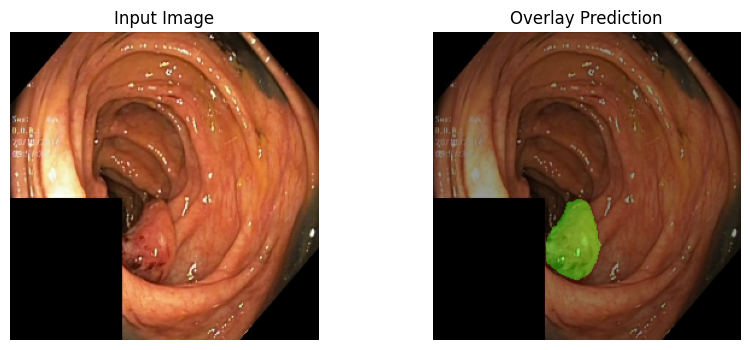

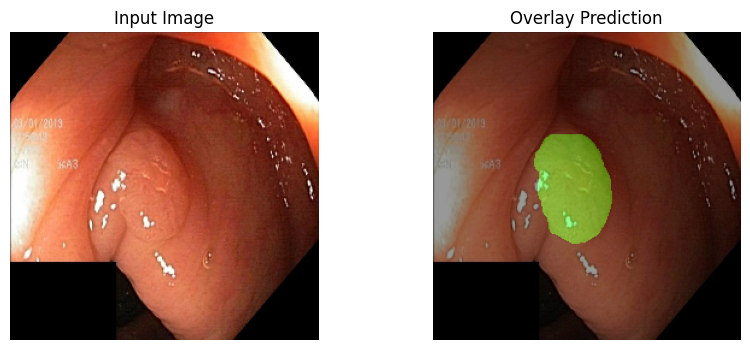

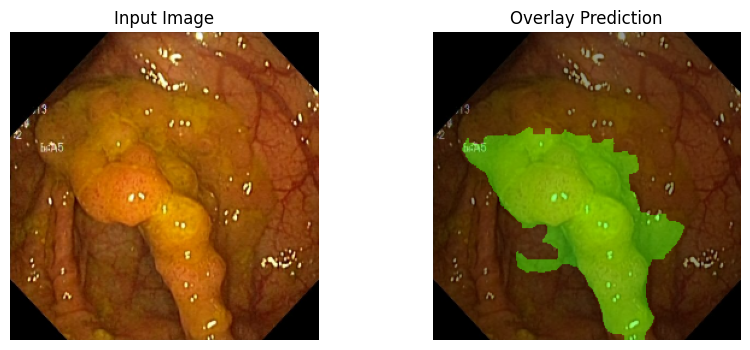

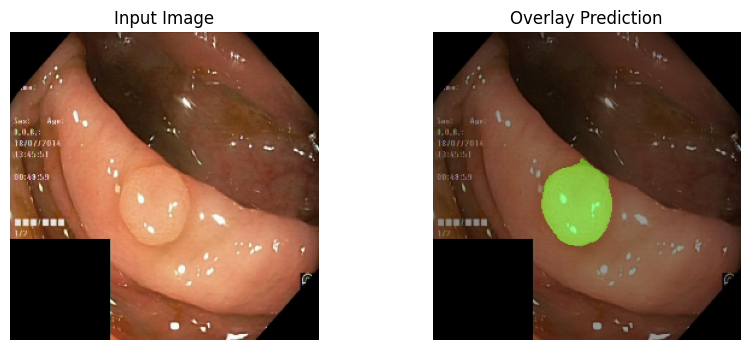

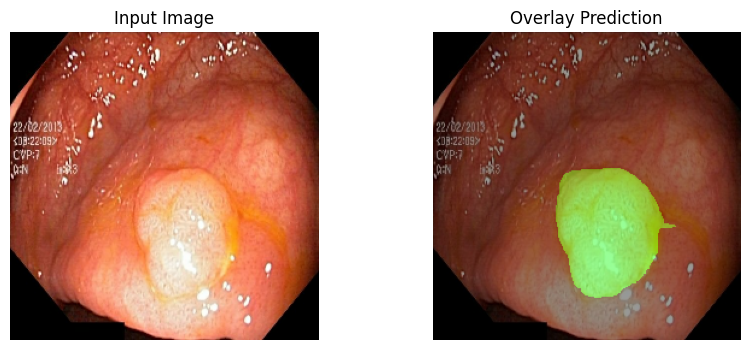

In [62]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt

sample_paths = random.sample(sorted(glob.glob(os.path.join(KVASIR_IMG_DIR, "*"))), 6)

for path in sample_paths:
    img = tf.image.decode_image(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, [256, 256])
    pred = generator(tf.expand_dims((img / 127.5) - 1.0, 0), training=False)[0].numpy()
    pred_bin = clean_mask(pred)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Input Image")
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Overlay Prediction")
    show_overlay(img.numpy()/255.0, np.expand_dims(pred_bin, -1))
    plt.show()


In [65]:
!kaggle datasets download -d balraj98/cvcclinicdb -p {DATA_DIR} --unzip


Dataset URL: https://www.kaggle.com/datasets/balraj98/cvcclinicdb
License(s): other
 99% 130M/131M [00:01<00:00, 69.7MB/s]
100% 131M/131M [00:01<00:00, 73.5MB/s]


In [66]:
!ls /content/polyp_data


class_dict.csv	Kvasir-SEG  metadata.csv  README.md  train.txt	    val.txt
images		masks	    PNG		  TIF	     unified_final


In [67]:
CVC_IMG_DIR = "/content/polyp_data/images"
CVC_MASK_DIR = "/content/polyp_data/masks"
import os

print("Images folder exists:", os.path.exists(CVC_IMG_DIR))
print("Masks folder exists:", os.path.exists(CVC_MASK_DIR))
print("Sample image files:", sorted(os.listdir(CVC_IMG_DIR))[:5])
print("Sample mask files:", sorted(os.listdir(CVC_MASK_DIR))[:5])
print("Total images:", len(os.listdir(CVC_IMG_DIR)))
print("Total masks:", len(os.listdir(CVC_MASK_DIR)))


Images folder exists: True
Masks folder exists: True
Sample image files: ['1.png', '10.png', '100.png', '101.png', '102.png']
Sample mask files: ['1.png', '10.png', '100.png', '101.png', '102.png']
Total images: 196
Total masks: 196


In [73]:
opt = tf.keras.optimizers.Adam(3e-5)

for epoch in range(5):
    losses = []
    for imgs, masks in make_source_dataset(CVC_IMG_DIR, CVC_MASK_DIR, batch_size=4, augment=True):
        with tf.GradientTape() as tape:
            preds = generator(imgs, training=True)
            loss = seg_loss(masks, preds)
        grads = tape.gradient(loss, generator.trainable_variables)
        opt.apply_gradients(zip(grads, generator.trainable_variables))
        losses.append(loss.numpy())
    print(f"🔁 Extra fine-tune epoch {epoch+1}: {np.mean(losses):.4f}")

generator.save_weights("/content/checkpoints_adapt/generator_finetuned_cvc_final_v2.weights.h5")
print("✅ Extra CVC fine-tuning completed and saved!")


Source pairs: 196
🔁 Extra fine-tune epoch 1: 0.3370
Source pairs: 196
🔁 Extra fine-tune epoch 2: 0.3053
Source pairs: 196
🔁 Extra fine-tune epoch 3: 0.3013
Source pairs: 196
🔁 Extra fine-tune epoch 4: 0.3071
Source pairs: 196
🔁 Extra fine-tune epoch 5: 0.3232
✅ Extra CVC fine-tuning completed and saved!


In [75]:
def show_predictions_on_dir(model, img_dir, n=6, threshold=0.2):
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2, os, random
    from skimage.morphology import remove_small_objects

    files = sorted(os.listdir(img_dir))[:n]
    plt.figure(figsize=(10, 5 * n))

    for i, fname in enumerate(files):
        img_path = os.path.join(img_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_input = cv2.resize(img, (256, 256)) / 255.0
        pred = model.predict(np.expand_dims(img_input, 0))[0, ..., 0]

        # lower threshold to catch faint masks
        pred_bin = (pred > threshold).astype(np.uint8)

        # clean small noise
        pred_bin = cv2.morphologyEx(pred_bin, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
        pred_bin = remove_small_objects(pred_bin.astype(bool), min_size=100).astype(np.uint8)

        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(pred_bin, cmap='gray')
        plt.title("Cleaned Predicted Mask (Threshold=0.2)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [81]:
def show_overlay_predictions(model, img_dir, n=6, threshold=0.2):
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2, os
    from skimage.morphology import remove_small_objects

    files = sorted(os.listdir(img_dir))[:n]
    plt.figure(figsize=(10, 5 * n))

    for i, fname in enumerate(files):
        img_path = os.path.join(img_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_input = cv2.resize(img, (256, 256)) / 255.0

        # model prediction
        pred = model.predict(np.expand_dims(img_input, 0))[0, ..., 0]

        # threshold + clean mask
        pred_bin = (pred > threshold).astype(np.uint8)
        pred_bin = cv2.morphologyEx(pred_bin, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
        pred_bin = remove_small_objects(pred_bin.astype(bool), min_size=100).astype(np.uint8)

        # resize mask back to original image size
        pred_bin_resized = cv2.resize(pred_bin, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        # overlay mask
        overlay = img.copy()
        overlay[pred_bin_resized == 1] = (
            0.3 * overlay[pred_bin_resized == 1] + 0.7 * np.array([0, 255, 0])
        ).astype(np.uint8)

        # show
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title("CVC Input Image")
        plt.axis("off")

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(overlay)
        plt.title("Overlay Prediction (Green = Polyp)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


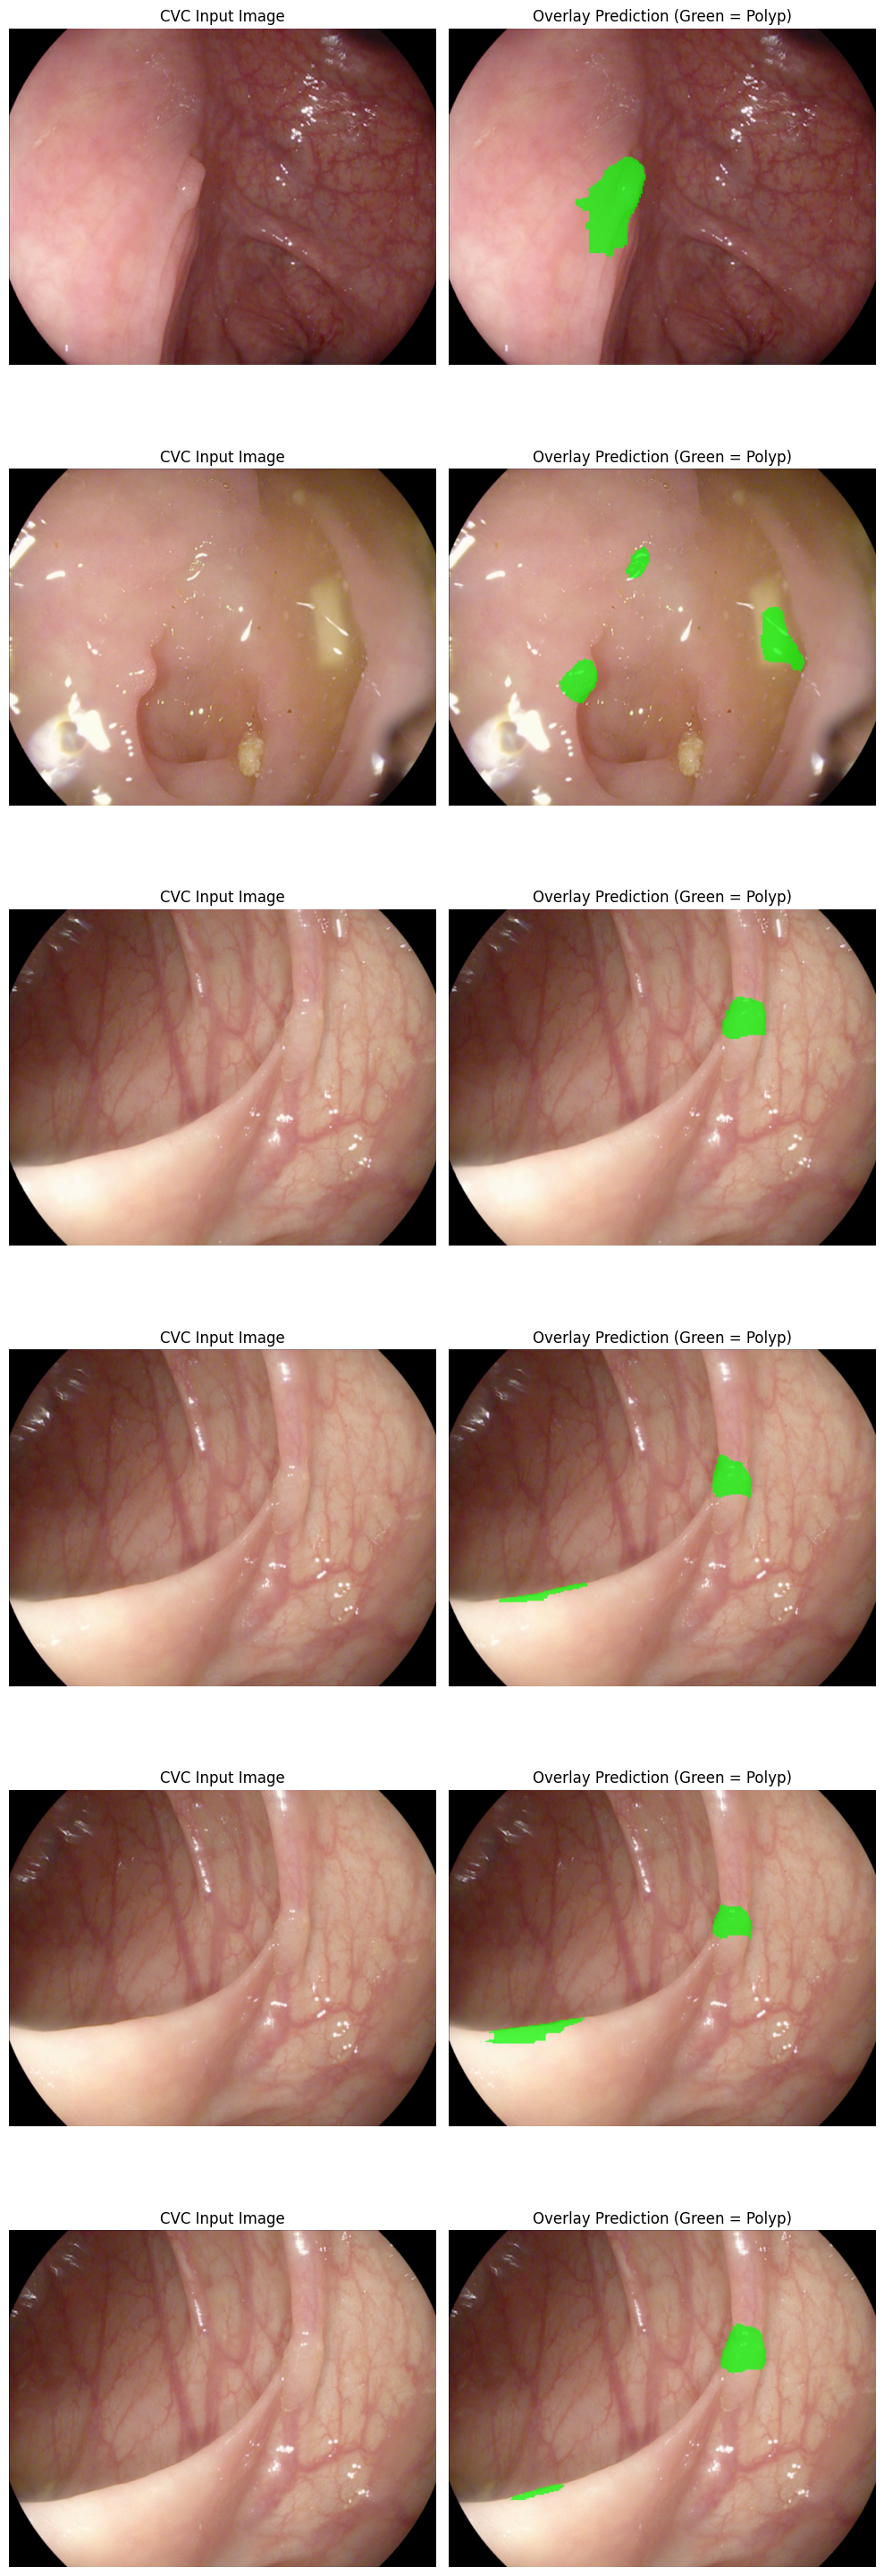

In [82]:
show_overlay_predictions(generator, CVC_IMG_DIR, n=6)


In [83]:
import os, shutil, glob

# Base unified folder
UNIFIED_IMG_DIR = "/content/unified_polyp_dataset/images"
UNIFIED_MASK_DIR = "/content/unified_polyp_dataset/masks"
os.makedirs(UNIFIED_IMG_DIR, exist_ok=True)
os.makedirs(UNIFIED_MASK_DIR, exist_ok=True)

# Dataset sources
datasets = {
    "kvasir": ("/content/polyp_data/Kvasir-SEG/Kvasir-SEG/images", "/content/polyp_data/Kvasir-SEG/Kvasir-SEG/masks"),
    "cvc": ("/content/polyp_data/images", "/content/polyp_data/masks"),
    "etis": ("/content/polyp_data/TIF/Original", None),  # ETIS may not have masks
}

# Copy from Kvasir and CVC
for name, (img_dir, mask_dir) in datasets.items():
    if mask_dir and os.path.exists(mask_dir):
        img_files = sorted(glob.glob(os.path.join(img_dir, "*")))
        mask_files = sorted(glob.glob(os.path.join(mask_dir, "*")))
        for img, mask in zip(img_files, mask_files):
            base = os.path.basename(img)
            shutil.copy(img, os.path.join(UNIFIED_IMG_DIR, f"{name}__{base}"))
            shutil.copy(mask, os.path.join(UNIFIED_MASK_DIR, f"{name}__{base}"))
print("✅ Unified dataset created with Kvasir + CVC (ETIS used later for testing)")


✅ Unified dataset created with Kvasir + CVC (ETIS used later for testing)


In [84]:
opt = tf.keras.optimizers.Adam(1e-5)

for epoch in range(10):
    losses = []
    for imgs, masks in make_source_dataset(UNIFIED_IMG_DIR, UNIFIED_MASK_DIR, batch_size=8, augment=True):
        with tf.GradientTape() as tape:
            preds = generator(imgs, training=True)
            loss = seg_loss(masks, preds)   # Dice + Focal loss combo
        grads = tape.gradient(loss, generator.trainable_variables)
        opt.apply_gradients(zip(grads, generator.trainable_variables))
        losses.append(loss.numpy())
    print(f"Unified fine-tune epoch {epoch+1}: {np.mean(losses):.4f}")

generator.save_weights("/content/checkpoints_adapt/generator_finetuned_unified.weights.h5")
print("✅ Unified model training completed and saved!")


Source pairs: 1196
Unified fine-tune epoch 1: 0.1232
Source pairs: 1196
Unified fine-tune epoch 2: 0.1051
Source pairs: 1196
Unified fine-tune epoch 3: 0.1021
Source pairs: 1196
Unified fine-tune epoch 4: 0.1069
Source pairs: 1196
Unified fine-tune epoch 5: 0.0986
Source pairs: 1196
Unified fine-tune epoch 6: 0.1009
Source pairs: 1196
Unified fine-tune epoch 7: 0.0963
Source pairs: 1196
Unified fine-tune epoch 8: 0.0977
Source pairs: 1196
Unified fine-tune epoch 9: 0.0985
Source pairs: 1196
Unified fine-tune epoch 10: 0.0998
✅ Unified model training completed and saved!


In [87]:
import numpy as np
import tensorflow as tf
import os
import cv2
from tqdm import tqdm

def compute_metrics(model, img_dir, mask_dir, threshold=0.5, limit=100):
    img_paths = sorted(os.listdir(img_dir))[:limit]
    dice_scores, iou_scores = [], []

    for fname in tqdm(img_paths, desc=f"Evaluating on {os.path.basename(img_dir)}"):
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".jpg", ".png").replace(".tif", ".png"))

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256)) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask = cv2.resize(mask, (256, 256))
        mask = np.where(mask > 127, 1.0, 0.0).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)


        pred = model.predict(np.expand_dims(img, 0))[0, :, :, 0]
        pred_bin = (pred > threshold).astype(np.float32)

        intersection = np.sum(pred_bin * mask)
        dice = (2. * intersection) / (np.sum(pred_bin) + np.sum(mask) + 1e-8)
        iou = intersection / (np.sum(pred_bin) + np.sum(mask) - intersection + 1e-8)
        dice_scores.append(dice)
        iou_scores.append(iou)

    return np.mean(dice_scores), np.mean(iou_scores)

# Paths for each dataset
datasets = {
    "Kvasir-SEG": ("/content/polyp_data/Kvasir-SEG/Kvasir-SEG/images", "/content/polyp_data/Kvasir-SEG/Kvasir-SEG/masks"),
    "CVC-ClinicDB": ("/content/polyp_data/images", "/content/polyp_data/masks"),
    "ETIS-Larib": ("/content/polyp_data/TIF/Original", None),  # ETIS has no masks
}

# Evaluate
results = {}
for name, (img_dir, mask_dir) in datasets.items():
    if mask_dir and os.path.exists(mask_dir):
        dice, iou = compute_metrics(generator, img_dir, mask_dir)
        results[name] = (dice, iou)
    else:
        results[name] = ("-", "-")

# Print comparison
print("\n📊 Unified Model Performance:")
print("Dataset\t\tDice\t\tIoU")
for name, (dice, iou) in results.items():
    print(f"{name:15s}\t{dice:.4f}\t\t{iou:.4f}" if dice != "-" else f"{name:15s}\tN/A\t\tN/A")


Evaluating on images:   0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Evaluating on images:   1%|          | 1/100 [00:03<05:01,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating on images:   2%|▏         | 2/100 [00:06<05:13,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:   3%|▎         | 3/100 [00:08<04:04,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:   4%|▍         | 4/100 [00:12<05:10,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:   5%|▌         | 5/100 [00:15<04:46,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Evaluating on images:   6%|▌         | 6/100 [00:17<04:12,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:   7%|▋         | 7/100 [00:20<04:38,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating on images:   8%|▊         | 8/100 [00:22<04:03,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating on images:   9%|▉         | 9/100 [00:27<04:53,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  10%|█         | 10/100 [00:29<04:15,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  11%|█         | 11/100 [00:33<05:04,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  12%|█▏        | 12/100 [00:35<04:27,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  13%|█▎        | 13/100 [00:40<04:57,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  14%|█▍        | 14/100 [00:41<04:09,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  15%|█▌        | 15/100 [00:46<04:42,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  16%|█▌        | 16/100 [00:48<04:07,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  17%|█▋        | 17/100 [00:51<04:08,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  18%|█▊        | 18/100 [00:55<04:37,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  19%|█▉        | 19/100 [00:58<04:08,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating on images:  20%|██        | 20/100 [01:01<04:11,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Evaluating on images:  21%|██        | 21/100 [01:03<03:50,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  22%|██▏       | 22/100 [01:07<04:01,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  23%|██▎       | 23/100 [01:08<03:26,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating on images:  24%|██▍       | 24/100 [01:11<03:30,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  25%|██▌       | 25/100 [01:13<03:10,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Evaluating on images:  26%|██▌       | 26/100 [01:17<03:19,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  27%|██▋       | 27/100 [01:18<02:54,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  28%|██▊       | 28/100 [01:20<02:45,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  29%|██▉       | 29/100 [01:24<03:06,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  30%|███       | 30/100 [01:26<02:53,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating on images:  31%|███       | 31/100 [01:30<03:30,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  32%|███▏      | 32/100 [01:32<03:00,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating on images:  33%|███▎      | 33/100 [01:35<03:11,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  34%|███▍      | 34/100 [01:38<02:59,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating on images:  35%|███▌      | 35/100 [01:41<03:14,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  36%|███▌      | 36/100 [01:44<02:56,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  37%|███▋      | 37/100 [01:48<03:26,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  38%|███▊      | 38/100 [01:51<03:15,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  39%|███▉      | 39/100 [01:54<03:10,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  40%|████      | 40/100 [01:58<03:16,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  41%|████      | 41/100 [02:00<02:59,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  42%|████▏     | 42/100 [02:05<03:21,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  43%|████▎     | 43/100 [02:07<03:04,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating on images:  44%|████▍     | 44/100 [02:10<02:58,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  45%|████▌     | 45/100 [02:12<02:28,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  46%|████▌     | 46/100 [02:16<02:57,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  47%|████▋     | 47/100 [02:19<02:37,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  48%|████▊     | 48/100 [02:23<03:01,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  49%|████▉     | 49/100 [02:27<02:52,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  50%|█████     | 50/100 [02:29<02:37,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  51%|█████     | 51/100 [02:33<02:48,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  52%|█████▏    | 52/100 [02:35<02:20,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  53%|█████▎    | 53/100 [02:39<02:34,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  54%|█████▍    | 54/100 [02:41<02:16,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating on images:  55%|█████▌    | 55/100 [02:45<02:19,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  56%|█████▌    | 56/100 [02:47<02:08,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  57%|█████▋    | 57/100 [02:52<02:31,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  58%|█████▊    | 58/100 [02:54<02:10,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  59%|█████▉    | 59/100 [02:58<02:17,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  60%|██████    | 60/100 [03:00<01:57,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating on images:  61%|██████    | 61/100 [03:03<01:50,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  62%|██████▏   | 62/100 [03:07<02:01,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating on images:  63%|██████▎   | 63/100 [03:09<01:44,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  64%|██████▍   | 64/100 [03:13<01:56,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating on images:  65%|██████▌   | 65/100 [03:17<02:02,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  66%|██████▌   | 66/100 [03:21<02:03,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  67%|██████▋   | 67/100 [03:23<01:40,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  68%|██████▊   | 68/100 [03:27<01:50,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  69%|██████▉   | 69/100 [03:29<01:36,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  70%|███████   | 70/100 [03:34<01:43,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  71%|███████   | 71/100 [03:36<01:31,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating on images:  72%|███████▏  | 72/100 [03:39<01:22,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating on images:  73%|███████▎  | 73/100 [03:43<01:30,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating on images:  74%|███████▍  | 74/100 [03:45<01:16,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  75%|███████▌  | 75/100 [03:49<01:20,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating on images:  76%|███████▌  | 76/100 [03:52<01:14,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating on images:  77%|███████▋  | 77/100 [03:55<01:12,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  78%|███████▊  | 78/100 [03:57<01:01,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  79%|███████▉  | 79/100 [04:01<01:06,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  80%|████████  | 80/100 [04:04<01:01,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  81%|████████  | 81/100 [04:08<01:03,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  82%|████████▏ | 82/100 [04:09<00:51,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  83%|████████▎ | 83/100 [04:11<00:43,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  84%|████████▍ | 84/100 [04:17<00:53,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images:  85%|████████▌ | 85/100 [04:19<00:44,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  86%|████████▌ | 86/100 [04:22<00:43,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating on images:  87%|████████▋ | 87/100 [04:24<00:34,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Evaluating on images:  88%|████████▊ | 88/100 [04:28<00:37,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating on images:  89%|████████▉ | 89/100 [04:29<00:29,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating on images:  90%|█████████ | 90/100 [04:33<00:28,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  91%|█████████ | 91/100 [04:34<00:22,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  92%|█████████▏| 92/100 [04:38<00:23,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Evaluating on images:  93%|█████████▎| 93/100 [04:41<00:20,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Evaluating on images:  94%|█████████▍| 94/100 [04:43<00:15,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  95%|█████████▌| 95/100 [04:47<00:14,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  96%|█████████▌| 96/100 [04:49<00:10,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Evaluating on images:  97%|█████████▋| 97/100 [04:52<00:08,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating on images:  98%|█████████▊| 98/100 [04:54<00:05,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluating on images:  99%|█████████▉| 99/100 [04:58<00:02,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluating on images: 100%|██████████| 100/100 [05:00<00:00,  3.00s/it]


📊 Unified Model Performance:
Dataset		Dice		IoU
Kvasir-SEG     	nan		nan
CVC-ClinicDB   	8.0656		22.4061
ETIS-Larib     	N/A		N/A


In [94]:
import numpy as np
import tensorflow as tf
import os
import cv2
from tqdm import tqdm

def compute_metrics(model, img_dir, mask_dir, threshold=0.5, limit=100):
    img_paths = sorted(os.listdir(img_dir))[:limit]
    dice_scores, iou_scores = [], []

    for fname in tqdm(img_paths, desc=f"Evaluating on {os.path.basename(img_dir)}"):
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".jpg", ".png").replace(".tif", ".png"))

        if not os.path.exists(mask_path):
            continue

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256)).astype(np.float32) / 255.0

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256)).astype(np.float32) / 255.0
        mask = np.where(mask > 0.5, 1.0, 0.0)
        mask = np.expand_dims(mask, axis=-1)

        # Model prediction
        pred = model.predict(np.expand_dims(img, 0), verbose=0)[0, :, :, 0]
        pred = np.clip(pred, 0, 1)
        pred_bin = (pred > threshold).astype(np.float32)

        # Dice & IoU
        intersection = np.sum(pred_bin * mask)
        dice = (2. * intersection) / (np.sum(pred_bin) + np.sum(mask) + 1e-8)
        iou = intersection / (np.sum(pred_bin) + np.sum(mask) - intersection + 1e-8)

        dice_scores.append(dice)
        iou_scores.append(iou)

    return np.mean(dice_scores), np.mean(iou_scores)


In [ ]:
dice, iou = compute_metrics(generator, "/content/polyp_data/images", "/content/polyp_data/masks")
print(f"CVC-ClinicDB Dice: {dice:.4f}, IoU: {iou:.4f}")


Evaluating on images:  79%|███████▉  | 79/100 [08:42<02:29,  7.14s/it]